In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import graphlab as gl
from graphlab.toolkits.feature_engineering import TFIDF, FeatureHasher, QuadraticFeatures

gl.canvas.set_target('ipynb')

PATH_TO_JSON2 = "/mnt/sframe/docs_prod_02/"
PATH_TO_JSON = "/mnt/sframe/docs_prod_03/"
PATH_TO_TRAIN_LABELS = "input/train.csv"
PATH_TO_TEST_LABELS = "input/sampleSubmission.csv"

[WARNING] This Python session does not appear to be running in an interactive IPython Notebook. Use of the 'ipynb' target may behave unexpectedly or result in errors.


### Read processed documents

In [2]:
gl.set_runtime_config('GRAPHLAB_DEFAULT_NUM_PYLAMBDA_WORKERS', 32)

[INFO] This trial license of GraphLab Create is assigned to renatbek@gmail.com and will expire on October 08, 2015. Please contact trial@dato.com for licensing options or to request a free non-commercial license for personal or academic use.

[INFO] Start server at: ipc:///tmp/graphlab_server-11692 - Server binary: /usr/local/lib/python2.7/site-packages/graphlab/unity_server - Server log: /tmp/graphlab_server_1442904105.log
[INFO] GraphLab Server Version: 1.5.2


In [3]:
# documents
sf = gl.SFrame.read_csv(PATH_TO_JSON, header=False, verbose=False)
sf = sf.unpack('X1',column_name_prefix='')
sf['id'] = sf['id'].apply(lambda x: str(x.split('_')[0] ))

sf2 = gl.SFrame.read_csv(PATH_TO_JSON2, header=False, verbose=False)
sf2 = sf2.unpack('X1',column_name_prefix='')
sf2['id'] = sf2['id'].apply(lambda x: str(x.split('_')[0] ))

------------------------------------------------------
Inferred types from first line of file as 
column_type_hints=[dict]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------
PROGRESS: Finished parsing file /mnt/sframe/docs_prod_03/49
PROGRESS: Read 5685 lines. Lines per second: 12472.4
PROGRESS: Finished parsing file /mnt/sframe/docs_prod_03/8
PROGRESS: Finished parsing file /mnt/sframe/docs_prod_03/23
PROGRESS: Finished parsing file /mnt/sframe/docs_prod_03/26
PROGRESS: Finished parsing file /mnt/sframe/docs_prod_03/3
PROGRESS: Finished parsing file /mnt/sframe/docs_prod_03/16
PROGRESS: Finished parsing file /mnt/sframe/docs_prod_03/5
PROGRESS: Finished parsing file /mnt/sframe/docs_prod_03/39
PROGRESS: Finished parsing file /mnt/sframe/docs_prod_03/60
PROGRESS: Finished parsing file /mnt/sframe/docs_prod_03/50
PROGRESS: Finished parsing f

In [4]:
def transf(x):
    return 50.0 * np.log1p(np.log1p(x))

sf_cnt = gl.SFrame()
sf_cnt['id'] = sf2['id']

sf_cnt['a_href'] = sf2['ahref'].apply(lambda x: transf(len(x)))
sf_cnt['par'] = sf2['par'].apply(lambda x: transf(len(x)))
sf_cnt['title'] = sf2['title'].apply(lambda x: transf(len(x)))

sf_cnt['img'] = sf2['img_cnt'].apply(transf)
sf_cnt['btn'] = sf2['misc_button'].apply(transf)
sf_cnt['input'] = sf2['misc_input'].apply(transf)
sf_cnt['li'] = sf2['misc_li'].apply(transf)
sf_cnt['link'] = sf2['misc_link'].apply(transf)
sf_cnt['meta'] = sf2['misc_meta'].apply(transf)

sf_cnt['script_avg'] = sf2['script_avg'].apply(transf)
sf_cnt['script_b_avg'] = sf2['script_b_avg'].apply(transf)
sf_cnt['script_cnt'] = sf2['script_cnt'].apply(transf)
sf_cnt['script_b_cnt'] = sf2['script_b_cnt'].apply(transf)

sf_cnt['style_avg'] = sf2['style_avg'].apply(transf)
sf_cnt['style_cnt'] = sf2['style_cnt'].apply(transf)

### Read train/test labels and merge into documents

In [6]:
# train/test labels
train_labels = gl.SFrame.read_csv(PATH_TO_TRAIN_LABELS, verbose=False)
test_labels = gl.SFrame.read_csv(PATH_TO_TEST_LABELS, verbose=False)
train_labels['id'] = train_labels['file'].apply(lambda x: str(x.split('_')[0] ))
train_labels = train_labels.remove_column('file')
test_labels['id'] = test_labels['file'].apply(lambda x: str(x.split('_')[0] ))
test_labels = test_labels.remove_column('file')

# join
train = train_labels.join(sf, on='id', how='left')
test = test_labels.join(sf, on='id', how='left')

train = train.join(sf_cnt, on='id', how='left')
test = test.join(sf_cnt, on='id', how='left')

------------------------------------------------------
Inferred types from first line of file as 
column_type_hints=[str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------
PROGRESS: Finished parsing file /mnt/data/input/train.csv
PROGRESS: Parsing completed. Parsed 337024 lines in 0.117093 secs.
------------------------------------------------------
Inferred types from first line of file as 
column_type_hints=[str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------
PROGRESS: Finished parsing file /mnt/data/input/sampleSubmission.csv
PROGRESS: Parsing completed. Parsed 66772 lines in 0.047664 secs.


In [58]:
features = ['a_href',
            'par',
            'title',
            'img',
            'btn',
            'input',
            'li',
            'link',
            'meta',
            'script_avg',
            'script_b_avg',
            'script_cnt',
            'script_b_cnt',
            'style_avg',
            'style_cnt']

for f in features:
    train_train = train_train.fillna(f, 0.0)     
    train_cv = train_cv.fillna(f, 0.0)

### Generate BOW

In [9]:
bow_trn = gl.text_analytics.count_words(train['text'])
bow_trn = bow_trn.dict_trim_by_keys(gl.text_analytics.stopwords())

bow_tst = gl.text_analytics.count_words(test['text'])
bow_tst = bow_tst.dict_trim_by_keys(gl.text_analytics.stopwords())

train['bow'] = bow_trn
test['bow'] = bow_tst

### Generate TF-IDF

In [10]:
encoder = gl.feature_engineering.create(train, TFIDF('bow', output_column_name='tfidf', min_document_frequency=1e-5))
train = encoder.transform(train)
test = encoder.transform(test)

### Hash TF-IDF

In [54]:
hash_encoder = gl.feature_engineering.create(train, FeatureHasher(features = ['tfidf'], num_bits=18, 
                                                                  output_column_name='tfidf_hashed_18'))
train['tfidf_hashed_18'] = hash_encoder.transform(train)['tfidf_hashed_18']
test['tfidf_hashed_18'] = hash_encoder.transform(test)['tfidf_hashed_18']

# Generate Submission Model

In [ ]:
model = gl.logistic_classifier.create(train, target='sponsored', 
                                      features=['tfidf_hashed'],
                                      validation_set=None,
                                      class_weights='auto',
                                      max_iterations=10,
                                      l2_penalty=0.00,
                                      l1_penalty=0.00)

In [ ]:
svm_model = gl.svm_classifier.create(train, target='sponsored', 
                                      features=['tfidf_hashed'],
                                      validation_set=None,                                           
                                      class_weights='auto',
                                      max_iterations=20)

### Output model

In [ ]:
ypred = model.predict(test, 'probability')

submission = gl.SFrame()
submission['file'] = test['id'].apply(lambda x: x + '_raw_html.txt')
submission['sponsored'] = ypred 
submission.save('submission_version_4.csv', format='csv')

submission = submission.to_dataframe()
submission.to_csv('submission_version_4.csv', index=False, float_format='%1.8f')

# Experiment

### Split train into *train_train*/*train_cv*

In [55]:
train_train_18, train_cv_18 = train.random_split(0.80, seed=107)

In [ ]:
model = gl.logistic_classifier.create(train_train, target='sponsored', 
                                      features=features, # + ['tfidf_hashed'],
                                      validation_set=train_cv,
                                      class_weights='auto',
                                      max_iterations=10,
                                      feature_rescaling=True,
                                      l2_penalty=0.00,
                                      l1_penalty=0.00)

In [ ]:
results = gl.SFrame()
results['id'] = train_cv['id']
results['actual'] = train_cv['sponsored']
results['predicted'] = model.predict(train_cv)

In [ ]:
train_cv.unpack('tfidf')

In [ ]:
FN.shape, FP.shape

In [ ]:
FN = results[results['actual'] > results['predicted']]
FP = results[results['actual'] < results['predicted']]

In [ ]:
FN[720:730]

In [ ]:
FP

In [ ]:
model.evaluate(train_cv)

In [ ]:
results = model.evaluate(train_cv, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
train_cv.remove_column('tfidf_hashed17')

In [ ]:
svm_model = gl.svm_classifier.create(train_train, target='sponsored', 
                                      features=features + ['tfidf_hashed'],
                                      validation_set=train_cv,                                           
                                      class_weights='auto',
                                      max_iterations=15)

In [ ]:
svm_model

In [ ]:
train_cv['margin'] = svm_model.predict(train_cv, output_type='margin')
preds = train_cv[['sponsored', 'margin']].sort('margin')
train_cv.remove_column('margin')

pd_preds = preds.to_dataframe()
pd_preds['number'] = 1.0

pd_preds_cum = pd_preds.cumsum()

total_positives = np.asarray(pd_preds_cum['sponsored'])[-1]
total = np.asarray(pd_preds_cum['number'])[-1]
total_negatives = total - total_positives

pd_preds_cum['FN'] = pd_preds_cum['sponsored']
pd_preds_cum['TN'] = pd_preds_cum['number'] - pd_preds_cum['sponsored']

pd_preds_cum['TP'] = total_positives - pd_preds_cum['FN']
pd_preds_cum['FP'] = total - total_positives - pd_preds_cum['TN']

pd_preds_cum['fpr'] = pd_preds_cum['FP'] / (pd_preds_cum['FP'] + pd_preds_cum['TN'])
pd_preds_cum['tpr'] = pd_preds_cum['TP'] / (pd_preds_cum['TP'] + pd_preds_cum['FN'])



In [ ]:
a = pd_preds_cum

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
train_cv['margin'] = svm_model.predict(train_cv, output_type='margin')
preds = train_cv[['sponsored', 'margin']]
preds['margin'].show()

In [ ]:
(preds[preds['margin'] < 55]['sponsored']).sum()

In [ ]:
ts = np.arange(-22, 50, 0.1)
[for t in ts]

In [ ]:
svm_model.evaluate(train_cv)

In [ ]:
results = svm_model.evaluate(train_cv, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
results

# Save Datasets?

In [ ]:
train_train.save('dataset_train_train')
train_cv.save('dataset_train_cv')
test.save('dataset_test')

# Junk

In [ ]:
hash_encoder = gl.feature_engineering.create(train_train, FeatureHasher(features = ['tfidf'], num_bits=17, 
                                                                  output_column_name='tfidf_hashed_17'))
train_train['tfidf_hashed_17'] = hash_encoder.transform(train_train)['tfidf_hashed_17']
train_cv['tfidf_hashed_17'] = hash_encoder.transform(train_cv)['tfidf_hashed_17']

In [ ]:
train_train.head()

In [ ]:
model_15 = gl.logistic_classifier.create(train_train, target='sponsored', 
                                      features=['tfidf_hashed_15'],
                                      validation_set=train_cv,
                                      class_weights='auto',
                                      max_iterations=40,
                                      feature_rescaling=True,
                                      l2_penalty=0.00,
                                      l1_penalty=0.00)

In [ ]:
model_15

In [ ]:
model_15.evaluate(train_cv)

In [ ]:
results = model_15.evaluate(train_cv, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
model_16 = gl.logistic_classifier.create(train_train, target='sponsored', 
                                      features=['tfidf_hashed_16'],
                                      validation_set=train_cv,
                                      class_weights='auto',
                                      max_iterations=20,
                                      feature_rescaling=True,
                                      l2_penalty=0.00,
                                      l1_penalty=0.00)

In [ ]:
model_16.evaluate(train_cv)

In [ ]:
results = model_16.evaluate(train_cv, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
model_17 = gl.logistic_classifier.create(train_train, target='sponsored', 
                                      features=['tfidf_hashed_17'],
                                      validation_set=train_cv,
                                      class_weights=None, #'auto',
                                      max_iterations=8,
                                      feature_rescaling=True,
                                      l2_penalty=0.00,
                                      l1_penalty=0.00)

In [ ]:
model_17 = gl.logistic_classifier.create(train_train, target='sponsored', 
                                      features=['tfidf_hashed_17'],
                                      validation_set=train_cv,
                                      class_weights=None, #'auto',
                                      max_iterations=7,
                                      feature_rescaling=True,
                                      l2_penalty=0.00,
                                      l1_penalty=0.00)

In [ ]:
model_17.evaluate(train_cv)

In [ ]:
results = model_17.evaluate(train_cv, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
gl.svm_classifier.create(train_train, target='sponsored', 
                                      features=['tfidf_hashed_15'],
                                      validation_set=train_cv,                                           
                                      class_weights='auto',
                                      max_iterations=40)

In [ ]:
gl.svm_classifier.create(train_train, target='sponsored', 
                                      features=['tfidf_hashed_16'],
                                      validation_set=train_cv,                                           
                                      class_weights='auto',
                                      max_iterations=40)

In [ ]:
gl.svm_classifier.create(train_train, target='sponsored', 
                                      features=['tfidf_hashed_17'],
                                      validation_set=train_cv,                                           
                                      class_weights='auto',
                                      max_iterations=40)

In [ ]:
train.head()

In [79]:
#train_train.save('/mnt/sframe/counts_and_tfidf_hashed_18_split_train_train')
#train_cv.save('/mnt/sframe/counts_and_tfidf_hashed_18_split_train_cv')
#train_train = gl.load_sframe('/mnt/sframe/tfidf_hashed_16_split_train_train')
#train_cv = gl.load_sframe('/mnt/sframe/tfidf_hashed_16_split_train_cv')

In [ ]:
train_train.head()

In [ ]:
model = gl.classifier.random_forest_classifier.create?

In [56]:
train_train_16 = train_train
train_cv_16 = train_cv
train_train = train_train_18
train_cv = train_cv_18

In [77]:
b

PROGRESS: WARNING: Detected extremely low variance for feature(s) 'tfidf_hashed_18' because all entries are nearly the same.
Proceeding with model training using all features. If the model does not provide results of adequate quality, exclude the above mentioned feature(s) from the input dataset.
PROGRESS: Random forest classifier:
PROGRESS: --------------------------------------------------------
PROGRESS: Number of examples          : 269988
PROGRESS: Number of classes           : 2
PROGRESS: Number of feature columns   : 16
PROGRESS: Number of unpacked features : 214795
PROGRESS: Starting Boosted Trees
PROGRESS: --------------------------------------------------------
PROGRESS:   Iter      Accuracy          Elapsed time
PROGRESS:         (training) (validation)
PROGRESS:      0   9.613e-01   7.572e-01       11.02s
PROGRESS:      1   9.636e-01   7.815e-01       19.46s
PROGRESS:      2   9.699e-01   7.934e-01       27.34s
PROGRESS:      3   9.743e-01   8.017e-01       35.20s
PROGRESS:

AUC = 0.944399


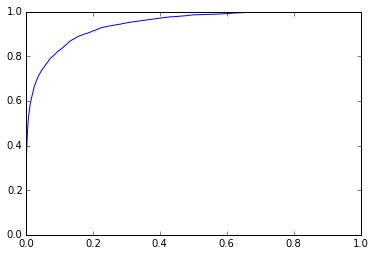

In [78]:
results = model.evaluate(train_cv, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
model_boosted = gl.classifier.boosted_trees_classifier.create(train_train, target='sponsored',
                                                      features=features + ['tfidf_hashed_18'],
                                                      max_depth=6,
                                                      step_size=0.3,
                                                      max_iterations=10,
                                                      column_subsample=0.45,
                                                      row_subsample=1.0,
                                                      class_weights='auto',
                                                      validation_set=train_cv)

In [80]:
gl.boosted_trees_classifier.get_default_options()

name,default_value,description,lower_bound,parameter_type,upper_bound
min_loss_reduction,0.0,Minimun loss reductionrequired for splitting a ...,0,REAL,3.40282346639e+38
class_weights,None,Weights (during training)assigned to each class. ...,None,DYNAMIC,None
step_size,0.3,Step_size used forcombining the weight of ...,0,REAL,1.0
min_child_weight,0.1,Minimum weight requiredon the leave nodes ...,0,REAL,3.40282346639e+38
column_subsample,1.0,Percentage of thefeatures(columns) sam ...,0,REAL,1.0
row_subsample,1.0,Percentage of theexamples (rows) for ...,0,REAL,1.0
max_depth,6.0,The maximum depth ofindividual trees ...,1,INTEGER,2147483647.0
max_iterations,10.0,"Number of iterations,equals to the number of ...",1,INTEGER,2147483647.0


In [12]:
train

sponsored,id,text,a_href,par,title,img
0,920982,bill gate world richestmost time beaten norweg ...,80.9005654591,59.7352761659,78.5001487104,47.956741946
0,920988,credit netflix fandomleah tedesco follow ...,91.3477694121,69.8681740587,74.8217008302,64.5862336364
0,920992,bimota,0.0,0.0,63.5574924142,0.0
0,921036,make your reflect yourpoint across with thi ...,93.0436382317,26.329451707,83.4236762641,71.4922773645
0,921040,play music suppos remembsometim electron ...,87.1068371903,70.9803420755,82.6201544047,78.5001487104
0,921050,ecogrid ecorast ecogridecorast ecogrid ecorast ...,83.5500516371,67.185172233,83.6744408005,63.5574924142
0,921108,topic sunday polic chargyear jeffrey william ...,83.0320189667,76.9889728976,82.7598076253,64.5862336364
1,921123,celebr your passion hobbiwith great video more ...,69.2613429966,70.4399908075,81.5685200098,51.33360156
1,921127,local queri searchlanguag countri ...,54.0208909136,0.0,78.5001487104,0.0
0,921130,they necess mother inventwhat they neglect men ...,92.4373694772,72.8823191511,82.3333585635,76.7097003339
